Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

In [1]:
# Install packages
!pip install pandas-profiling==2.*

     |████████████████████████████████| 266kB 3.5MB/s 
     |████████████████████████████████| 604kB 7.9MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 3.1MB 18.8MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 296kB 41.8MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=8c1b8c15e83b10c3a0b9c6f393c0de4e721239d711de020e2a583685c1e49b78
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for imagehash: filename=ImageHash-4.1.0-py2.py3-none-any.whl size=291991 sha256=bd6c082f7d1c2d35a3883af211d36e507a773b12aebdfe1f1e958120f50b7b9c
  Stored in directory: /root/.cache/pip/wheels/07/1c/dc/6831446f09feb8cc199ec73a0f2f0703253f6ae013a22f4be9
Successfully built htmlmin imagehash
  Found existing installation: tqdm 4.41.1
    Uni

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
# Read New York City property sales data
import pandas as pd
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

Your code starts here:

In [4]:
# We'll upload our file to our google colab
from google.colab import files
uploaded = files.upload()

Saving Build-Week-Dataset.csv to Build-Week-Dataset.csv


In [21]:
# Import pandas and io, make our dataset
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['Build-Week-Dataset.csv']), )
# Dataset is now stored in a Pandas Dataframe

In [22]:
# Take a look at the dataset
df.head()

,Unnamed: 0,Dependent-Company Status,year of founding,Age of company in years,Internet Activity Score,Industry of company,Focus functions of company,Investors,Employee Count,Employees count MoM change,Has the team size grown,Est. Founding Date,Last Funding Date,Last Funding Amount,Country of company,Continent of company,Number of Investors in Seed,Number of Investors in Angel and or VC,Number of Co-founders,Number of of advisors,Team size Senior leadership,Team size all employees,Presence of a top angel or venture fund in previous round of investment,Number of of repeat investors,Number of Sales Support material,Worked in top companies,Average size of companies worked for in the past,Have been part of startups in the past?,Have been part of successful startups in the past?,Was he or she partner in Big 5 consulting?,Consulting experience?,Product or service company?,Catering to product/service across verticals,Focus on private or public data?,Focus on consumer data?,Focus on structured or unstructured data,Subscription based business,Cloud or platform based serive/product?,Local or global player,Linear or Non-linear business model,...,Company awards,Controversial history of founder or co founder,Legal risk and intellectual property,Client Reputation,google page rank of company website,Technical proficiencies to analyse and interpret unstructured data,Solutions offered,Invested through global incubation competitions?,Industry trend in investing,Disruptiveness of technology,Number of Direct competitors,Employees per year of company existence,Last round of funding received (in milionUSD),"Survival through recession, based on existence of the company through recession times",Time to 1st investment (in months),"Avg time to investment - average across all rounds, measured from previous investment",Gartner hype cycle stage,Time to maturity of technology (in years),Renown score,Market Research,Marketing,Analytics,Software Development,Mobile,Enterprise Software,Media,Cloud Computing,Network / Hosting / Infrastructure,Social Networking,Retail,Entertainment,Healthcare,Energy,Search,Food & Beverages,Music,Publishing,Gaming,Email,Career / Job Search
0,0,Success,NaN,NaN,-1.0,NaN,operation,KPCB Holdings|Draper Fisher Jurvetson (DFJ)|Kl...,3.0,0.0,No,NaN,5/26/2013,450000.0,United States,North America,2.0,0.0,1,2,2,15.0,Yes,4.0,Nothing,No,Small,No,No,No,No,Service,No,Private,No,Both,Yes,Platform,Global,Linear,...,No,No,No,NaN,9626884.0,No,Yes,No,2.0,Low,0.0,1.500000,0.45,NaN,NaN,11.560000,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Success,2011.0,3.0,125.0,Market Research|Marketing|Crowdfunding,"Marketing, sales",NaN,NaN,NaN,No,NaN,NaN,NaN,United States,North America,5.0,0.0,2,0,4,20.0,No,0.0,medium,Yes,Large,Yes,Yes,No,No,Product,No,Public,Yes,Both,No,Platform,Local,Non-Linear,...,No,No,Yes,Medium,1067034.0,Yes,Yes,No,3.0,Medium,0.0,6.666667,5,Not Applicable,10.0,9.000000,Trough,2 to 5,8.0,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,Success,2011.0,3.0,455.0,Analytics|Cloud Computing|Software Development,operations,TechStars|Streamlined Ventures|Amplify Partner...,14.0,0.0,No,12/1/2011,10/23/2013,2350000.0,United States,North America,15.0,0.0,3,0,7,10.0,No,0.0,low,Yes,Medium,No,No,No,No,Both,Yes,Private,Yes,Both,Yes,cloud,Local,Non-Linear,...,No,No,No,Low,71391.0,Yes,Yes,Yes,3.0,Medium,0.0,3.333333,2.35,Not Applicable,2.0,7.344444,Trough,2 to 5,9.0,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,Success,2009.0,5.0,-99.0,Mobile|Analytics,Marketing & Sales,Michael Birch|Max Levchin|Sequoia Capital|Keit...,45.0,10.0,No,6/20/2009,5/10/2012,10250000.0,United States,North America,6.0,0.0,2,0,4,50.0,Yes,0.0,low,No,Large,Yes,Yes,No,No,Product,Yes,Public,Yes,Structured,Yes,Platform,Local,Non-Linear,...,No,No,No,Low,11847.0,No,Yes,Yes,4.0,

In [23]:
# We'll drop the extra column from importing the dataframe
df.drop('Unnamed: 0', inplace=True, axis=1)

In [25]:
# We'll also encode our true and false observations for the industries
df = df.replace({True: 1, False: 0})

In [26]:
# Wrangle our data
def wrangle(X):
  # Make a copy
  X = X.copy()
  cols = ['Industry of company', 'Age of company in years', 'Investors', 'Last Funding Date', 'Continent of company', 'Team size all employees', 'Years of education']
  X.drop(columns=cols, inplace=True)
  # X = X[X['amount_tsh'].between(X['amount_tsh'].quantile(0.02), X['amount_tsh'].quantile(0.98))]

  return X

In [27]:
# Make our dataframe into the wrangled form
df = wrangle(df)

In [28]:
# Look at the dataframe now.
df.head()

,Dependent-Company Status,year of founding,Internet Activity Score,Focus functions of company,Employee Count,Employees count MoM change,Has the team size grown,Est. Founding Date,Last Funding Amount,Country of company,Number of Investors in Seed,Number of Investors in Angel and or VC,Number of Co-founders,Number of of advisors,Team size Senior leadership,Presence of a top angel or venture fund in previous round of investment,Number of of repeat investors,Number of Sales Support material,Worked in top companies,Average size of companies worked for in the past,Have been part of startups in the past?,Have been part of successful startups in the past?,Was he or she partner in Big 5 consulting?,Consulting experience?,Product or service company?,Catering to product/service across verticals,Focus on private or public data?,Focus on consumer data?,Focus on structured or unstructured data,Subscription based business,Cloud or platform based serive/product?,Local or global player,Linear or Non-linear business model,"Capital intensive business e.g. e-commerce, Engineering products and operations can also cause a business to be capital intensive",Number of of Partners of company,Crowdsourcing based business,Crowdfunding based business,Machine Learning based business,Predictive Analytics business,Speech analytics business,...,Company awards,Controversial history of founder or co founder,Legal risk and intellectual property,Client Reputation,google page rank of company website,Technical proficiencies to analyse and interpret unstructured data,Solutions offered,Invested through global incubation competitions?,Industry trend in investing,Disruptiveness of technology,Number of Direct competitors,Employees per year of company existence,Last round of funding received (in milionUSD),"Survival through recession, based on existence of the company through recession times",Time to 1st investment (in months),"Avg time to investment - average across all rounds, measured from previous investment",Gartner hype cycle stage,Time to maturity of technology (in years),Renown score,Market Research,Marketing,Analytics,Software Development,Mobile,Enterprise Software,Media,Cloud Computing,Network / Hosting / Infrastructure,Social Networking,Retail,Entertainment,Healthcare,Energy,Search,Food & Beverages,Music,Publishing,Gaming,Email,Career / Job Search
0,Success,NaN,-1.0,operation,3.0,0.0,No,NaN,450000.0,United States,2.0,0.0,1,2,2,Yes,4.0,Nothing,No,Small,No,No,No,No,Service,No,Private,No,Both,Yes,Platform,Global,Linear,Yes,None,No,No,No,No,No,...,No,No,No,NaN,9626884.0,No,Yes,No,2.0,Low,0.0,1.500000,0.45,NaN,NaN,11.560000,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Success,2011.0,125.0,"Marketing, sales",NaN,NaN,No,NaN,NaN,United States,5.0,0.0,2,0,4,No,0.0,medium,Yes,Large,Yes,Yes,No,No,Product,No,Public,Yes,Both,No,Platform,Local,Non-Linear,No,Few,Yes,No,Yes,Yes,No,...,No,No,Yes,Medium,1067034.0,Yes,Yes,No,3.0,Medium,0.0,6.666667,5,Not Applicable,10.0,9.000000,Trough,2 to 5,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Success,2011.0,455.0,operations,14.0,0.0,No,12/1/2011,2350000.0,United States,15.0,0.0,3,0,7,No,0.0,low,Yes,Medium,No,No,No,No,Both,Yes,Private,Yes,Both,Yes,cloud,Local,Non-Linear,No,Few,No,No,No,Yes,No,...,No,No,No,Low,71391.0,Yes,Yes,Yes,3.0,Medium,0.0,3.333333,2.35,Not Applicable,2.0,7.344444,Trough,2 to 5,9.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Success,2009.0,-99.0,Marketing & Sales,45.0,10.0,No,6/20/2009,10250000.0,United States,6.0,0.0,2,0,4,Yes,0.0,low,No,Large,Yes,Yes,No,No,Product,Yes,Public,Yes,Structured,Yes,Platform,Local,Non-Linear,No,Few,Yes,No,No,No,No,...,No,No,No,Low,11847.0,No,Yes,Yes,4.0,Medium,2.0,10.000000,10.25,Not Applicable,1.0,8.700000,Trough,2 to 5,5.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Success,2010.0,496.0,Marketing & Sales,

In [16]:
# Make a profile report, save it
from pandas_profiling import ProfileReport

profile = ProfileReport(df)
profile.to_file('profile_report.html')

In [29]:
# Make our X and y dataframes.
X = df.drop('Dependent-Company Status', axis=1)
y = df['Dependent-Company Status']

In [30]:
# Import train test split
from sklearn.model_selection import train_test_split

In [32]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [52]:
# Look at the classes
y_train.value_counts()

Success    240
Failed     114
Name: Dependent-Company Status, dtype: int64

## Make our baseline


In [35]:
print("From our baseline, the probability of our guess being correct is:", y_test.value_counts(normalize=True).max())

From our baseline, the probability of our guess being correct is: 0.5508474576271186


## Make Pipeline

We'll try to make a quick model to beat the guess.

In [37]:
# Import everything
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [38]:
# Make the pipeline
 model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

In [39]:
# Fit our data
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Focus functions of company',
                                      'Has the team size grown',
                                      'Est. Founding Date',
                                      'Country of company',
                                      'Presence of a top angel or venture fund '
                                      'in previous round of investment',
                                      'Number of  Sales Support material',
                                      'Worked in top companies',
                                      'Average size of companies worked for in '
                                      'the past',
                                      'Have been part of startups in the past?'...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                  

<Figure size 576x576 with 0 Axes>

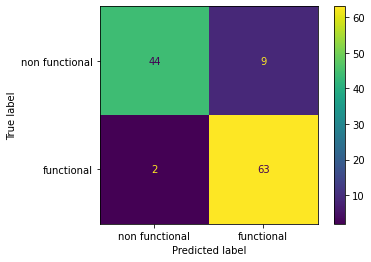

In [44]:
# Plot a confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,8))

plot_confusion_matrix(model, X_test, y_test,
                      display_labels=['non functional', 'functional' , 'functional but needs repairs'],
                      )

fig.clf()

In [46]:
# Check our metrics
print('LOG: Training Accuracy:', model.score(X_train, y_train))
print('LOG: Validation Accuracy:', model.score(X_test, y_test))

LOG: Training Accuracy: 1.0
LOG: Validation Accuracy: 0.9067796610169492


In [48]:
# Check for imbalanced classes
y_test.value_counts(normalize=True)

Success    0.550847
Failed     0.449153
Name: Dependent-Company Status, dtype: float64

In [50]:
# Import metrics
from sklearn import metrics

In [51]:
# See our precision and recall
y_pred = model.predict(X_test)
print (metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Failed       0.96      0.83      0.89        53
     Success       0.88      0.97      0.92        65

    accuracy                           0.91       118
   macro avg       0.92      0.90      0.90       118
weighted avg       0.91      0.91      0.91       118



` Really good scores so far. Although this might be too good to be true, most likely due to the imbalanced classes. This model, however, is already performing far better than the baseline `